### Importing Libraries

In [143]:
import os
import random
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
from torchvision import transforms
from torchvision.transforms import InterpolationMode

# Familiarization

## AI Images
First we will extract the extensions of the files so that we know what files we are dealing with. We will find all unique file extensions and provide some general statistics about them

In [28]:
from collections import Counter

# Find all unique file extensions in the given directory
def get_extension_counts(path):
    all_files = list(path.glob("*"))
    extensions = [file.suffix.lower() for file in all_files if file.is_file()]
    return Counter(extensions)

In [29]:
ai_data_path = Path("../data/AiArtData/AiArtData/")

extension_counts = get_extension_counts(ai_data_path)

print("AI Images - File extensions found:")
for ext, count in sorted(extension_counts.items()):
    print(f"  {ext}: {count} {count == 1 and 'file' or 'files'}")

print(f"Total files: {sum(extension_counts.values())}")
print(f"Unique extensions: {list(extension_counts.keys())}")


AI Images - File extensions found:
  .jpeg: 36 files
  .jpg: 385 files
  .png: 115 files
  .webp: 3 files
Total files: 539
Unique extensions: ['.png', '.jpg', '.jpeg', '.webp']


We can see that most of the files are .jpg and .png, but there are actually 3 .webp files that we could have missed if we had not gone through this step

We will now display 7 random AI images to familiarize ourselves with how AI images are supposed to look like. Futhermore we will also display their sizes, in order to see if they are the same size.

In [30]:
## Function to display random images in a grid from the given list of images
def display_random_images(image_list, num_images=4):
    rows = num_images//3 if num_images % 3 == 0 else (num_images // 3) + 1 # '//' floors the division 
    # Scale figsize based on number of rows and columns (3 columns)
    figsize = (15, rows * 4)  # 15 width for 3 columns, 4 inches per row
    fig, axes = plt.subplots(rows, 3, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array to 1D so we can index axes correctly
    
    for idx, img_path in enumerate(random.sample(image_list, min(num_images, len(image_list)))):
        # Load the image
        ai_image = Image.open(img_path)
        
        # Display the image
        axes[idx].imshow(ai_image)
        axes[idx].axis('off')  # Remove axes for cleaner look
        axes[idx].set_title(f"{img_path.name}\nSize: {ai_image.size}", fontsize=12)
    
    
    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

539 AI-generated images found.



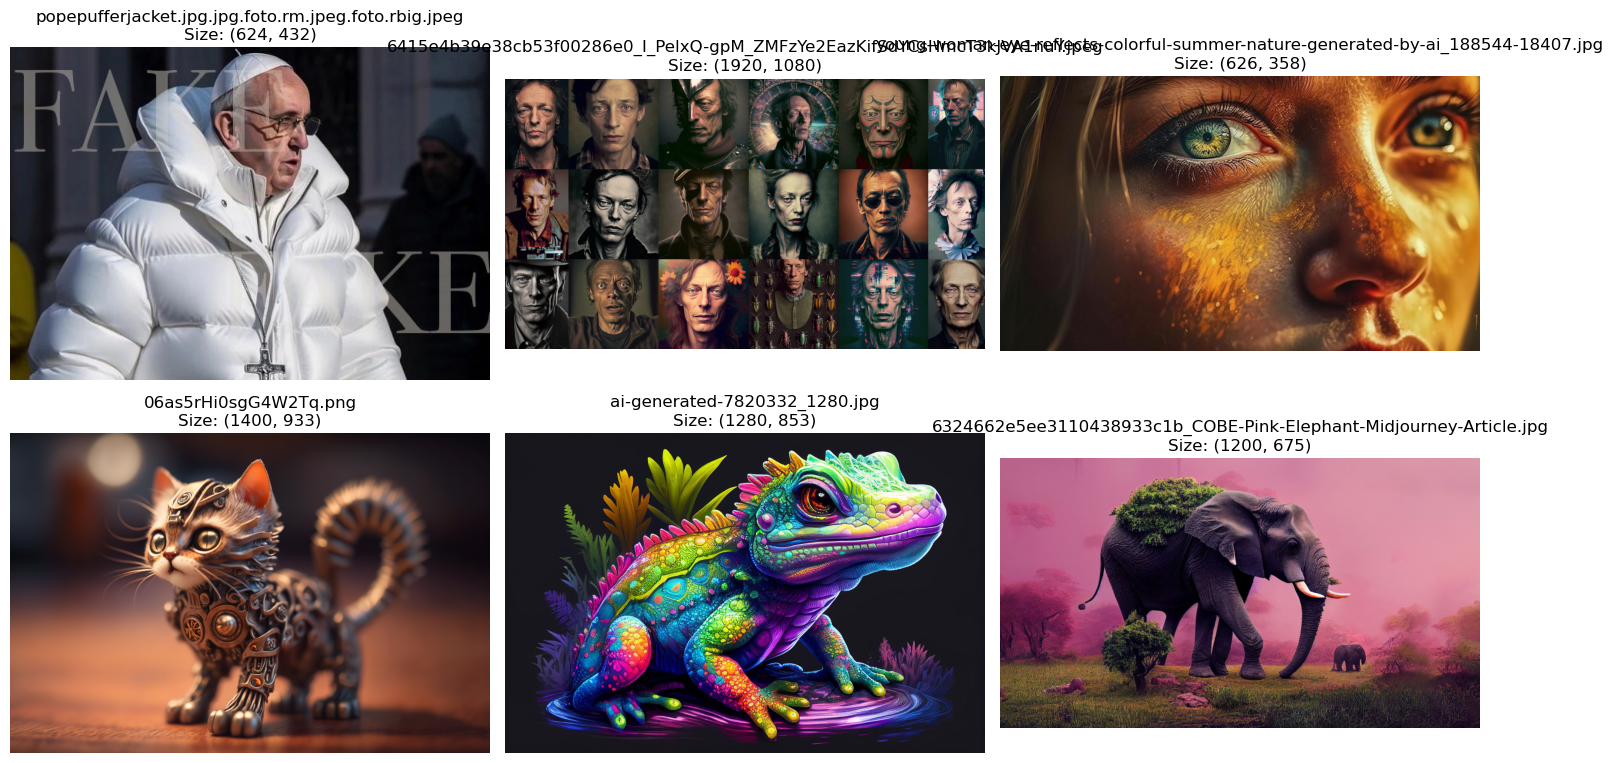

In [31]:
# Get all image files using glob with multiple extensions
ai_images_data = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
    ai_images_data.extend(ai_data_path.glob(ext))

print(f"{len(ai_images_data)} AI-generated images found.\n")

if ai_images_data:
    # Display 6 random images in a grid
    display_random_images(ai_images_data, 6)
else:
    print("No images found in the directory")

It is important to note that images are of different size, so we need to take that into consideration during pre-processing

## Real Images
We will now do the same analysis for the real images.

In [32]:
real_data_path = Path("../data/RealArt/RealArt/")

extension_counts = get_extension_counts(real_data_path)

print("Real Images - File extensions found:")
for ext, count in sorted(extension_counts.items()):
    print(f"  {ext}: {count} {count == 1 and 'file' or 'files'}")

print(f"Total files: {sum(extension_counts.values())}")
print(f"Unique extensions: {list(extension_counts.keys())}")

Real Images - File extensions found:
  : 1 file
  .gif: 1 file
  .jpeg: 21 files
  .jpg: 378 files
  .png: 35 files
Total files: 436
Unique extensions: ['.png', '.jpg', '.jpeg', '', '.gif']


We can see that glob has captured 1 file with its extension being an empty string. We will find the file and display it in order to see if its an image and if its is, we will add it to our images.

1


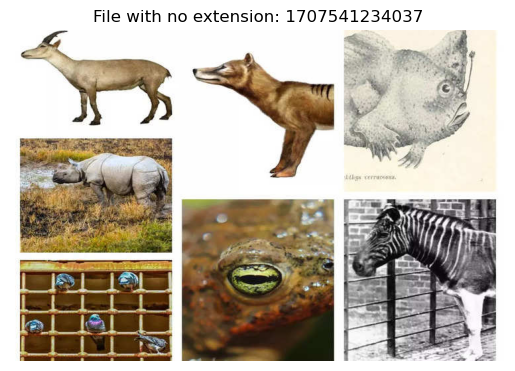

In [33]:
no_ext_files = [f for f in real_data_path.glob("*") if f.is_file() and f.suffix == ""]
print(len(no_ext_files))
for file in no_ext_files:
    img = Image.open(file)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"File with no extension: {file.name}")
    plt.show()

We can see that its clearly an image so we can safely add it to our set of real images

435 Real images found.



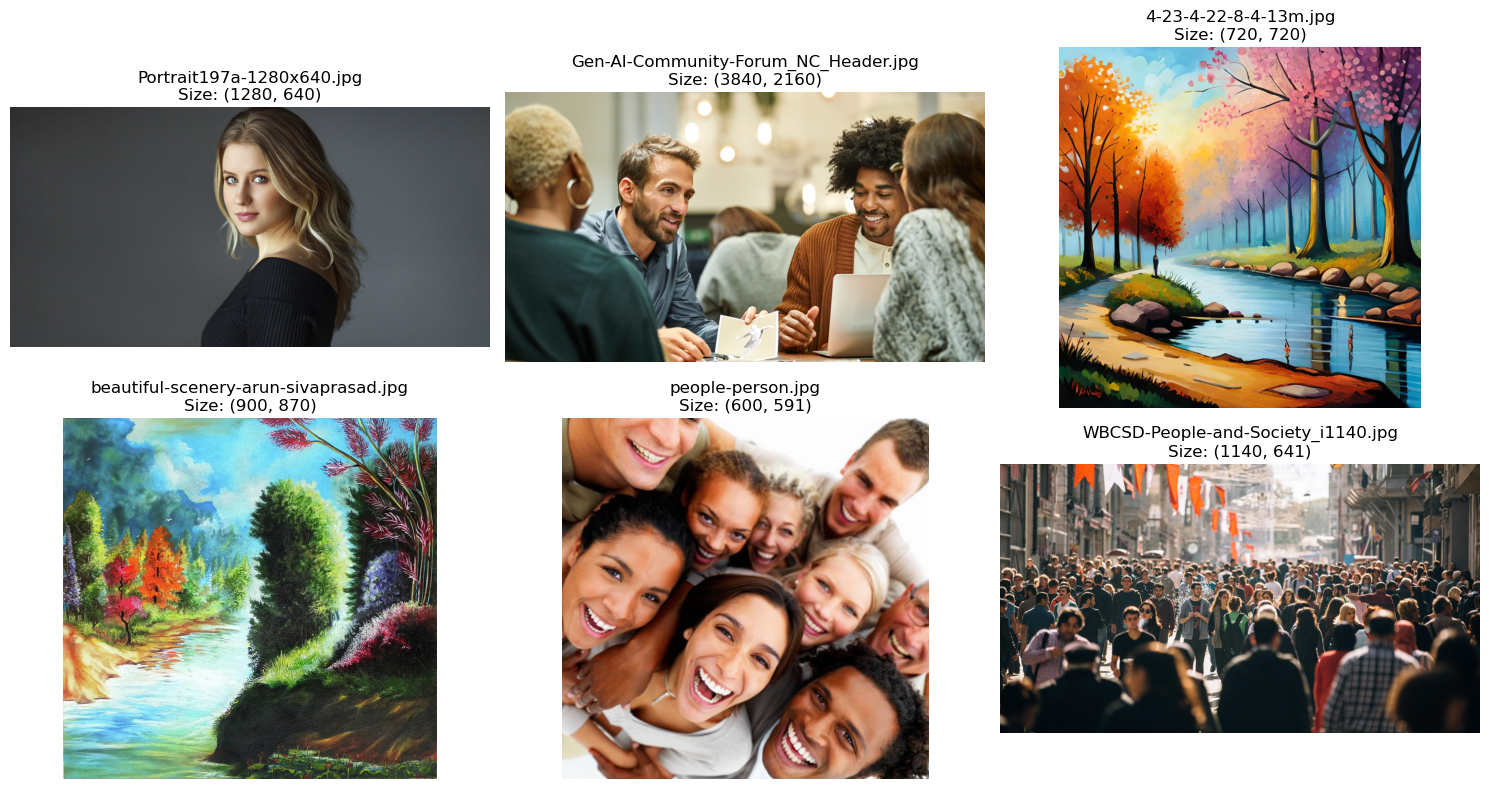

In [147]:
real_images_data = []
for file in no_ext_files:
    real_images_data.append(file)
# Add extensions
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
    real_images_data.extend(real_data_path.glob(ext))
print(f"{len(real_images_data)} Real images found.\n")

if real_images_data:
    # Display 6 random images in a grid
    display_random_images(real_images_data, 6)
else:
    print("No images found in the directory")

## Image properties inspection

We will now inspect the properties of an image so that we can notice if there is anything important to take into consideration during pre-processing. We first define our function which will print general image statistics given the image's path

In [123]:
# Function to print general image statistics
def inspect_image(image_path, label):
    image_prototype = Image.open(image_path)

    img_np = np.array(image_prototype)
    channels = 1 if len(img_np.shape) == 2 else img_np.shape[2]
    print(
        f"{label} Image Prototype\n"
        "\n"
        f"Format: {image_prototype.format}\n"
        f"Mode:   {image_prototype.mode}\n"
        f"Size:   {image_prototype.size}\n"
        f"Channels: {channels}\n"
        f"Min pixel value: {img_np.min()}\n"
        f"Max pixel value: {img_np.max()}\n"
        f"Mean pixel value: {img_np.mean()}\n"
        f"Std pixel value: {img_np.std()}\n"  
    )
    if img_np.ndim == 3:
            for i, c in enumerate(["R", "G", "B"]):
                print(f"{c} mean: {img_np[..., i].mean():.2f}, "
                    f"{c} std: {img_np[..., i].std():.2f}")
    print("--------------------")
    return image_prototype



We now call our newly defined function for 10 random images per class so that we can spot differences

In [130]:

for i in range(10):
    ai_image_prototype = inspect_image(random.choice(ai_images_data), "AI-generated")
    real_image_prototype = inspect_image(random.choice(real_images_data), "Real")


AI-generated Image Prototype

Format: JPEG
Mode:   RGB
Size:   (1600, 840)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 94.39155853174603
Std pixel value: 72.40931672912072

R mean: 106.55, R std: 72.58
G mean: 93.82, G std: 73.04
B mean: 82.81, B std: 69.60
--------------------
Real Image Prototype

Format: JPEG
Mode:   RGB
Size:   (236, 291)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 134.88494282330558
Std pixel value: 75.73712446033011

R mean: 133.01, R std: 75.96
G mean: 135.67, G std: 75.88
B mean: 135.98, B std: 75.33
--------------------
AI-generated Image Prototype

Format: JPEG
Mode:   RGB
Size:   (1280, 720)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 58.374754412615744
Std pixel value: 61.15113875361148

R mean: 60.58, R std: 72.94
G mean: 54.28, G std: 57.61
B mean: 60.26, B std: 50.53
--------------------
Real Image Prototype

Format: JPEG
Mode:   RGB
Size:   (480, 360)
Channels: 3
Min pixel val

 - We can clearly see that there is a large disbalance in the size of the images (width, height). Our model might learn these differences and classify images as AI just based on their size. This is something we want to avoid at all costs so we will have to pick one size and resize all images
 - Most of the images that we see over the iterations are RGB, but we can not conclude that there are not any images that have a different mode
 - Futhermore images have different means and stds, which we should also take into consideration when normalizing the data. It could be the case that AI images are brighter than Real ones, but we should avoid making a decision only based on this

### Dataset Plots
We will now create several plots to summarize and confirm the differences that we saw in the last cell

## 1. Width and Height Histogram
Since we noted that this might be the biggest problem in our classification model, we will now insect them next to each other

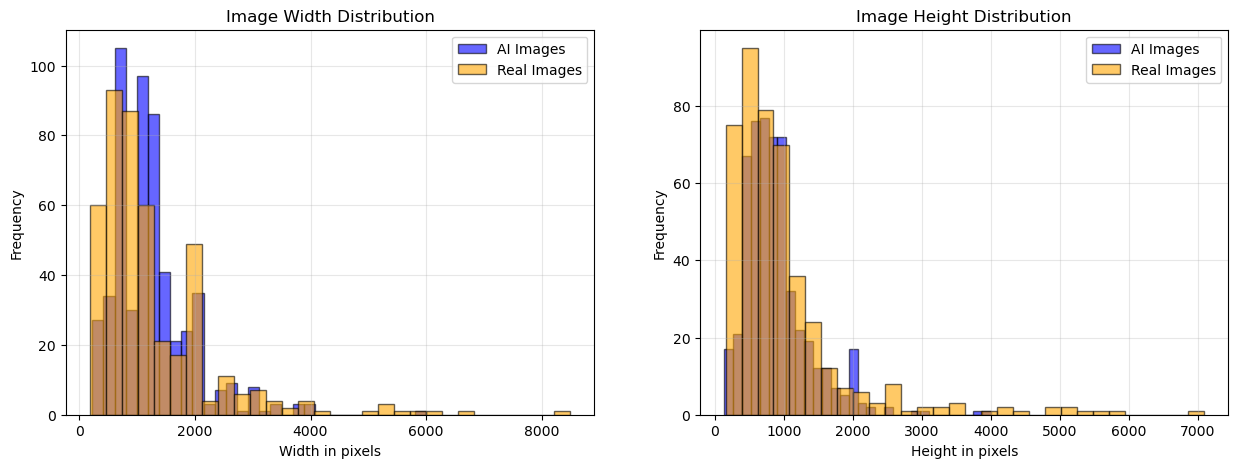

Width Statistics:
  AI Images - Mean: 1227.20, Std: 684.11, Min: 225, Max: 6000
  Real Images - Mean: 1253.24, Std: 1045.02, Min: 183, Max: 8495

Height Statistics:
  AI Images - Mean: 899.19, Std: 485.55, Min: 135, Max: 4001
  Real Images - Mean: 992.88, Std: 924.58, Min: 158, Max: 7091


In [139]:
# Collect width and height information for both datasets
ai_widths = []
ai_heights = []
real_widths = []
real_heights = []

# Extract dimensions from AI images
for img_path in ai_images_data:
    img = Image.open(img_path)
    ai_widths.append(img.size[0])
    ai_heights.append(img.size[1])

# Extract dimensions from Real images
for img_path in real_images_data:
    img = Image.open(img_path)
    real_widths.append(img.size[0])
    real_heights.append(img.size[1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Width histogram
axes[0].hist(ai_widths, bins=30, alpha=0.6, label='AI Images', color='blue', edgecolor='black')
axes[0].hist(real_widths, bins=30, alpha=0.6, label='Real Images', color='orange', edgecolor='black')
axes[0].set_xlabel('Width in pixels')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Height histogram
axes[1].hist(ai_heights, bins=30, alpha=0.6, label='AI Images', color='blue', edgecolor='black')
axes[1].hist(real_heights, bins=30, alpha=0.6, label='Real Images', color='orange', edgecolor='black')
axes[1].set_xlabel('Height in pixels')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

# Print summary statistics
print("Width Statistics:")
print(f"  AI Images - Mean: {np.mean(ai_widths):.2f}, Std: {np.std(ai_widths):.2f}, Min: {np.min(ai_widths)}, Max: {np.max(ai_widths)}")
print(f"  Real Images - Mean: {np.mean(real_widths):.2f}, Std: {np.std(real_widths):.2f}, Min: {np.min(real_widths)}, Max: {np.max(real_widths)}")
print("\nHeight Statistics:")
print(f"  AI Images - Mean: {np.mean(ai_heights):.2f}, Std: {np.std(ai_heights):.2f}, Min: {np.min(ai_heights)}, Max: {np.max(ai_heights)}")
print(f"  Real Images - Mean: {np.mean(real_heights):.2f}, Std: {np.std(real_heights):.2f}, Min: {np.min(real_heights)}, Max: {np.max(real_heights)}")

- As we can see both max width and max height are bigger for the Real Images. This means that on average AI-generated images are smaller in comparison with Real ones.
- Variance is huge in both classes. 
- There are long heavy tails, especially for the real images.
- There exist outliers - up to 8500 px wide and 7000 px tall

The dataset inspection shows large variability in image resolutions with heavy-tailed distributions, particularly for real images. This constitutes a potential shortcut cue for CNNs. Therefore, we must standardize image resolution during preprocessing.

## Preprocessing

We now start with preprocessing which will enable us to work with the images in such a way that there is no involved bias.

As we said Width/height distributions show heavy variability and long tails, especially for real images. This is a potential shortcut cue. Therefore we standardize input resolution during preprocessing.


We need to convert our images to tensors so that our Convolutional Neural Network can use them. To do so , we convert all images to RGB, so that all of them are in the same color mode. Then we resize them to 224 x 224 using bilineear interpolation. By using Bilinear Interpolation we average the pixels together and scale the image down while preserving information about the image.

In [145]:
from PIL import Image

image_to_tensor = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

img = Image.open(ai_images_data[0])
print("Before:", img.mode, img.size, type(img))

x = image_to_tensor(img)
print("After:", x.shape, x.dtype, x.min().item(), x.max().item(), type(x))

Before: RGB (1200, 800) <class 'PIL.JpegImagePlugin.JpegImageFile'>
After: torch.Size([3, 224, 224]) torch.float32 0.0 1.0 <class 'torch.Tensor'>
